# LSTM
CNN_264 with LSTM.

In [35]:
from datetime import datetime
print(datetime.now())

2023-03-27 21:32:48.521143


In [36]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [37]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=64 
FILTERSIZE=8
RCELLS=16
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [38]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [39]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [40]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [41]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    rnn1_layer = LSTM(RCELLS, return_sequences=True) 
    drop1_layer = Dropout(0.5) 
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop2_layer = Dropout(0.5) 
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(drop1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop2_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [42]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-27 21:32:51.318829
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 4997, 4)           1028      
                                                                 
 lstm_18 (LSTM)              (None, 4997, 16)          1344      
                                                                 
 dropout_31 (Dropout)        (None, 4997, 16)          0         
                                                                 
 time_distributed_18 (TimeDi  (None, 4997, 16)         272       
 stributed)                                                      
                                                                 
 flatten_18 (Flatten)        (None, 79952)             0         
                                                                 
 dropout_32 (Dropout)        (None, 79952)             0         
                          

## Training

In [43]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [44]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-27 21:32:51.705176
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-27 21:32:59.487405

Training # 1 1
2023-03-27 21:32:59.488997
2023-03-27 21:32:59.489069
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-27 21:33:00.908332


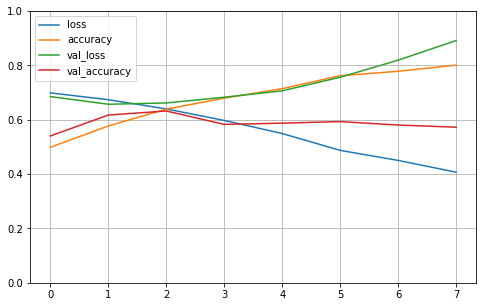


2023-03-27 21:35:25.018805

Testing # 1 1
2023-03-27 21:35:25.019214
2023-03-27 21:35:25.019248
PREDICT
2023-03-27 21:35:25.256883
Test 1:0 458:412 52.64%
Predict 1:0 464:406 53.33%
Test sizes (870, 4997) (870,)
Range of scores: 0.0002309914 to 0.99917346
Score threshold 0.5
Confusion matrix
 [[223 189]
 [183 275]]
Normalized matrix
 [[0.25632184 0.21724138]
 [0.21034483 0.31609195]]


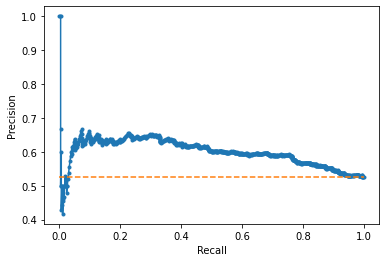

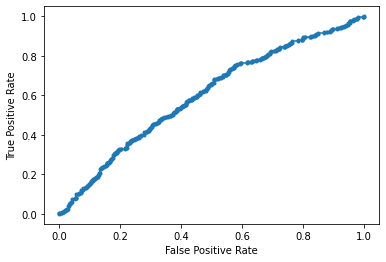

Accuracy: 57.24% Precision: 59.27% Recall: 60.04%
F1: 59.65% MCC: 0.1418
AUPRC: 60.02% AUROC: 60.07%
 accuracy [57.24137931034483]
 precision [59.26724137931034]
 recall [60.043668122270745]
 F1 [59.65292841648589]
 MCC [0.14181610879672069]
 AUPRC [60.01908339112201]
 AUROC [60.065926145758255]
2023-03-27 21:35:27.232518

Training # 1 2
2023-03-27 21:35:27.232650
2023-03-27 21:35:27.232693
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-27 21:35:28.576514


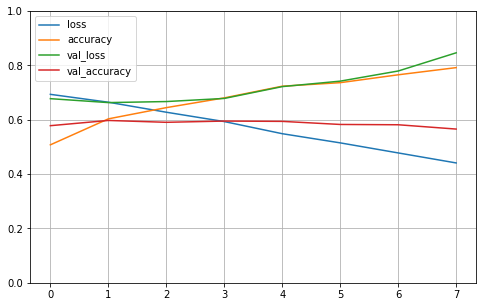


2023-03-27 21:37:54.122956

Testing # 1 2
2023-03-27 21:37:54.123051
2023-03-27 21:37:54.123086
PREDICT
2023-03-27 21:37:54.341709
Test 1:0 442:442 50.00%
Predict 1:0 454:430 51.36%
Test sizes (884, 4997) (884,)
Range of scores: 0.000912442 to 0.9992828
Score threshold 0.5
Confusion matrix
 [[244 198]
 [186 256]]
Normalized matrix
 [[0.2760181  0.2239819 ]
 [0.21040724 0.28959276]]


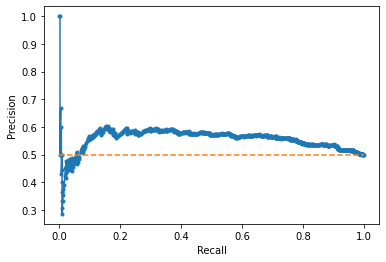

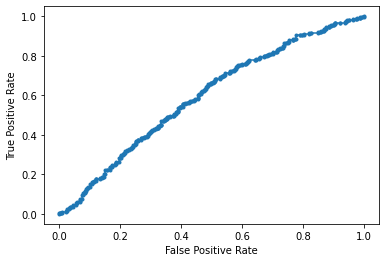

Accuracy: 56.56% Precision: 56.39% Recall: 57.92%
F1: 57.14% MCC: 0.1313
AUPRC: 55.70% AUROC: 59.48%
 accuracy [56.56108597285068]
 precision [56.38766519823789]
 recall [57.9185520361991]
 F1 [57.14285714285715]
 MCC [0.13127010703087566]
 AUPRC [55.703498773932594]
 AUROC [59.476669191867494]
2023-03-27 21:37:56.363807

Training # 1 3
2023-03-27 21:37:56.363948
2023-03-27 21:37:56.363991
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-27 21:37:57.729199


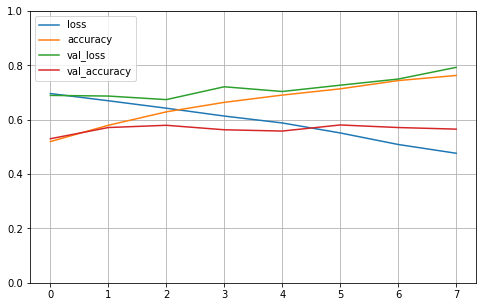


2023-03-27 21:39:32.018107

Testing # 1 3
2023-03-27 21:39:32.018208
2023-03-27 21:39:32.018244
PREDICT
2023-03-27 21:39:32.225951
Test 1:0 442:407 52.06%
Predict 1:0 407:442 47.94%
Test sizes (849, 4997) (849,)
Range of scores: 0.0011626463 to 0.9867643
Score threshold 0.5
Confusion matrix
 [[240 167]
 [202 240]]
Normalized matrix
 [[0.28268551 0.196702  ]
 [0.23792697 0.28268551]]


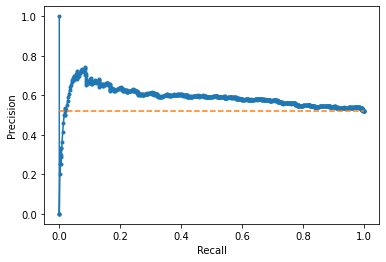

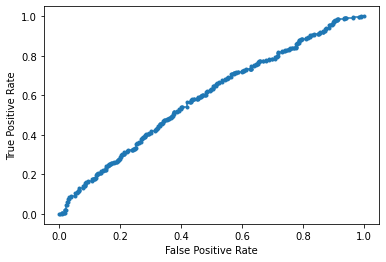

Accuracy: 56.54% Precision: 58.97% Recall: 54.30%
F1: 56.54% MCC: 0.1327
AUPRC: 58.89% AUROC: 59.03%
 accuracy [56.53710247349824]
 precision [58.96805896805897]
 recall [54.29864253393665]
 F1 [56.53710247349824]
 MCC [0.1326670150199562]
 AUPRC [58.88625288817244]
 AUROC [59.0264266734855]
2023-03-27 21:39:34.059747

Training # 1 4
2023-03-27 21:39:34.059901
2023-03-27 21:39:34.059942
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-27 21:39:35.434723


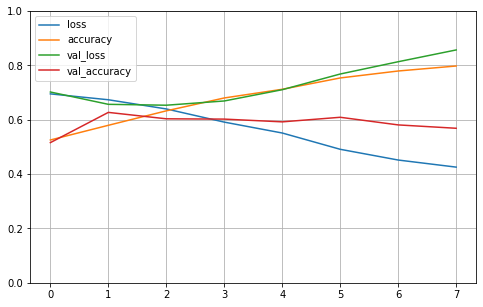


2023-03-27 21:41:14.232991

Testing # 1 4
2023-03-27 21:41:14.233096
2023-03-27 21:41:14.233130
PREDICT
2023-03-27 21:41:14.460048
Test 1:0 459:431 51.57%
Predict 1:0 463:427 52.02%
Test sizes (890, 4997) (890,)
Range of scores: 0.0006336104 to 0.9989793
Score threshold 0.5
Confusion matrix
 [[237 194]
 [190 269]]
Normalized matrix
 [[0.26629213 0.21797753]
 [0.21348315 0.30224719]]


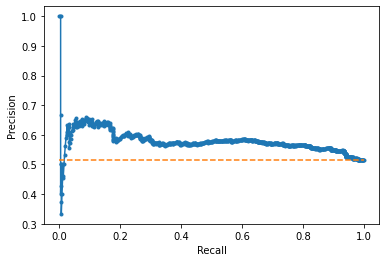

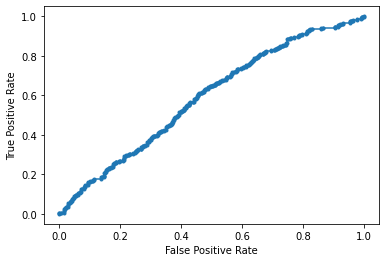

Accuracy: 56.85% Precision: 58.10% Recall: 58.61%
F1: 58.35% MCC: 0.1360
AUPRC: 57.93% AUROC: 58.89%
 accuracy [56.853932584269664]
 precision [58.09935205183585]
 recall [58.605664488017425]
 F1 [58.35140997830802]
 MCC [0.13598463534103383]
 AUPRC [57.92950575846969]
 AUROC [58.88620980745998]
2023-03-27 21:41:17.820461

Training # 1 5
2023-03-27 21:41:17.821227
2023-03-27 21:41:17.821271
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-27 21:41:19.215254


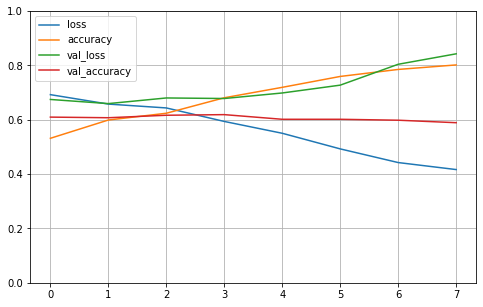


2023-03-27 21:43:43.358134

Testing # 1 5
2023-03-27 21:43:43.358224
2023-03-27 21:43:43.358258
PREDICT
2023-03-27 21:43:43.576515
Test 1:0 457:419 52.17%
Predict 1:0 479:397 54.68%
Test sizes (876, 4997) (876,)
Range of scores: 0.00608426 to 0.99906296
Score threshold 0.5
Confusion matrix
 [[228 191]
 [169 288]]
Normalized matrix
 [[0.26027397 0.21803653]
 [0.19292237 0.32876712]]


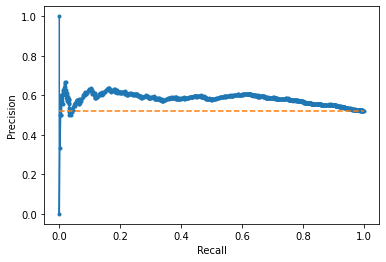

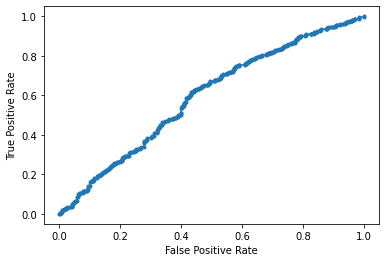

Accuracy: 58.90% Precision: 60.13% Recall: 63.02%
F1: 61.54% MCC: 0.1750
AUPRC: 58.21% AUROC: 59.36%
 accuracy [58.9041095890411]
 precision [60.125260960334025]
 recall [63.01969365426696]
 F1 [61.53846153846154]
 MCC [0.174953751318675]
 AUPRC [58.209038871687135]
 AUROC [59.357749774131385]
2023-03-27 21:43:46.954714

Training # 2 1
2023-03-27 21:43:46.955346
2023-03-27 21:43:46.955390
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-27 21:43:48.356101


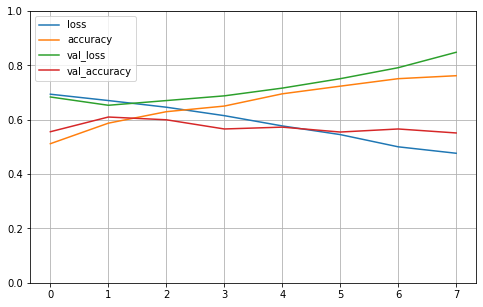


2023-03-27 21:46:12.456703

Testing # 2 1
2023-03-27 21:46:12.456804
2023-03-27 21:46:12.456838
PREDICT
2023-03-27 21:46:12.679358
Test 1:0 472:415 53.21%
Predict 1:0 528:359 59.53%
Test sizes (887, 4997) (887,)
Range of scores: 0.0030363582 to 0.99916327
Score threshold 0.5
Confusion matrix
 [[188 227]
 [171 301]]
Normalized matrix
 [[0.21195039 0.25591883]
 [0.19278467 0.33934611]]


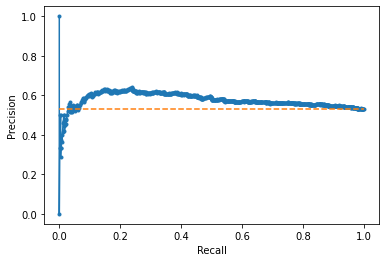

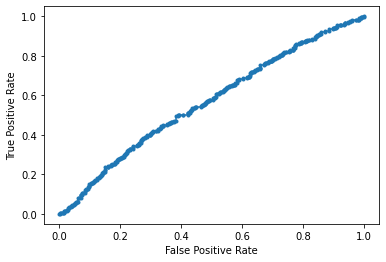

Accuracy: 55.13% Precision: 57.01% Recall: 63.77%
F1: 60.20% MCC: 0.0922
AUPRC: 57.58% AUROC: 56.68%
 accuracy [55.12965050732808]
 precision [57.00757575757576]
 recall [63.771186440677965]
 F1 [60.199999999999996]
 MCC [0.09222584300301849]
 AUPRC [57.58093547400034]
 AUROC [56.68062078823769]
2023-03-27 21:46:14.673494

Training # 2 2
2023-03-27 21:46:14.674140
2023-03-27 21:46:14.674184
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-27 21:46:16.060260


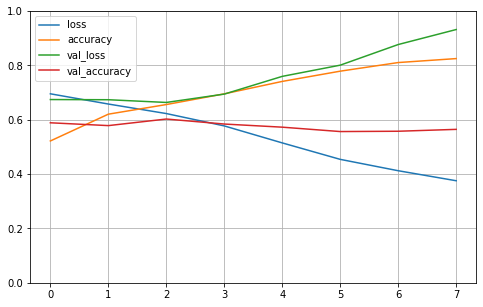


2023-03-27 21:47:54.423450

Testing # 2 2
2023-03-27 21:47:54.423570
2023-03-27 21:47:54.423611
PREDICT
2023-03-27 21:47:54.642713
Test 1:0 452:416 52.07%
Predict 1:0 512:356 58.99%
Test sizes (868, 4997) (868,)
Range of scores: 0.00032314027 to 0.99990666
Score threshold 0.5
Confusion matrix
 [[197 219]
 [159 293]]
Normalized matrix
 [[0.22695853 0.25230415]
 [0.18317972 0.3375576 ]]


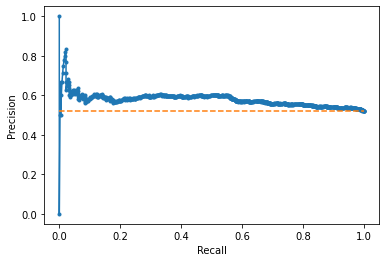

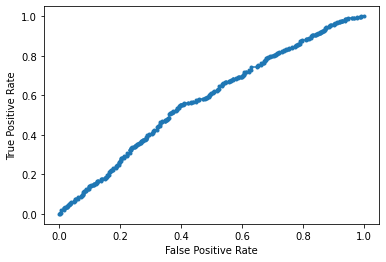

Accuracy: 56.45% Precision: 57.23% Recall: 64.82%
F1: 60.79% MCC: 0.1237
AUPRC: 57.80% AUROC: 57.98%
 accuracy [56.451612903225815]
 precision [57.2265625]
 recall [64.82300884955751]
 F1 [60.788381742738586]
 MCC [0.12369712909653047]
 AUPRC [57.797134591064115]
 AUROC [57.981620149761746]
2023-03-27 21:47:56.550394

Training # 2 3
2023-03-27 21:47:56.550525
2023-03-27 21:47:56.550565
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-27 21:47:57.932589


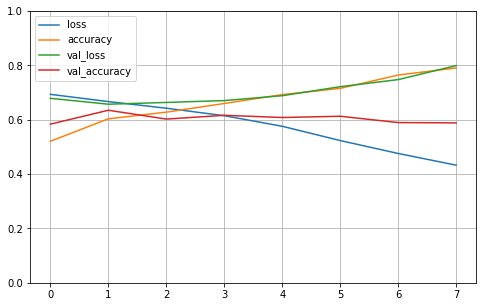


2023-03-27 21:49:33.340875

Testing # 2 3
2023-03-27 21:49:33.340982
2023-03-27 21:49:33.341017
PREDICT
2023-03-27 21:49:33.557787
Test 1:0 453:407 52.67%
Predict 1:0 431:429 50.12%
Test sizes (860, 4997) (860,)
Range of scores: 0.0029167342 to 0.99888784
Score threshold 0.5
Confusion matrix
 [[241 166]
 [188 265]]
Normalized matrix
 [[0.28023256 0.19302326]
 [0.21860465 0.30813953]]


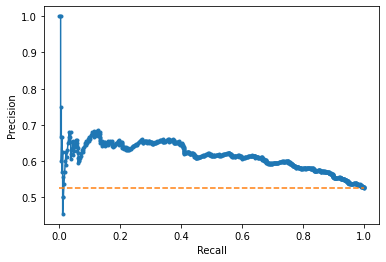

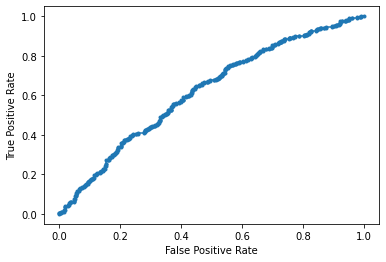

Accuracy: 58.84% Precision: 61.48% Recall: 58.50%
F1: 59.95% MCC: 0.1769
AUPRC: 61.56% AUROC: 61.97%
 accuracy [58.837209302325576]
 precision [61.48491879350348]
 recall [58.498896247240616]
 F1 [59.95475113122173]
 MCC [0.17687347135216272]
 AUPRC [61.562223185450016]
 AUROC [61.97124276594476]
2023-03-27 21:49:35.710897

Training # 2 4
2023-03-27 21:49:35.715467
2023-03-27 21:49:35.715827
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-27 21:49:38.135821


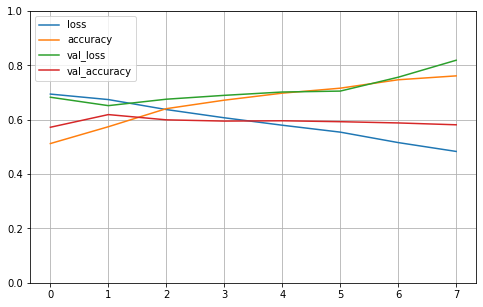


2023-03-27 21:51:15.331743

Testing # 2 4
2023-03-27 21:51:15.331843
2023-03-27 21:51:15.331884
PREDICT
2023-03-27 21:51:15.547817
Test 1:0 432:447 49.15%
Predict 1:0 524:355 59.61%
Test sizes (879, 4997) (879,)
Range of scores: 0.0114337 to 0.9978757
Score threshold 0.5
Confusion matrix
 [[217 230]
 [138 294]]
Normalized matrix
 [[0.24687144 0.26166098]
 [0.15699659 0.33447099]]


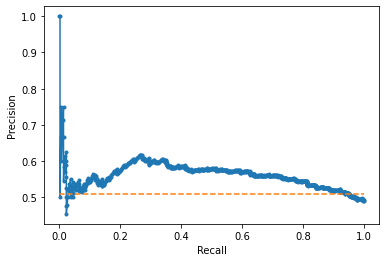

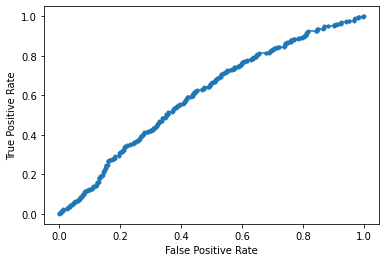

Accuracy: 58.13% Precision: 56.11% Recall: 68.06%
F1: 61.51% MCC: 0.1691
AUPRC: 56.13% AUROC: 60.42%
 accuracy [58.134243458475545]
 precision [56.10687022900763]
 recall [68.05555555555556]
 F1 [61.50627615062761]
 MCC [0.1691457030718666]
 AUPRC [56.133317718650254]
 AUROC [60.42029165630956]
2023-03-27 21:51:17.416498

Training # 2 5
2023-03-27 21:51:17.416624
2023-03-27 21:51:17.416666
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-27 21:51:18.759174


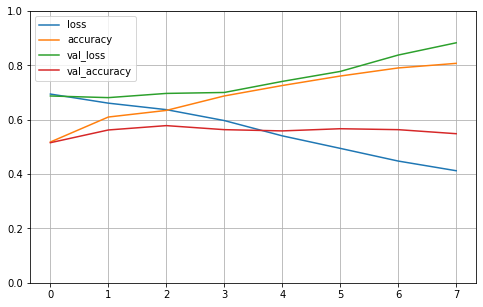


2023-03-27 21:53:44.071043

Testing # 2 5
2023-03-27 21:53:44.072396
2023-03-27 21:53:44.072715
PREDICT
2023-03-27 21:53:44.483965
Test 1:0 449:426 51.31%
Predict 1:0 372:503 42.51%
Test sizes (875, 4997) (875,)
Range of scores: 0.0005945785 to 0.99717087
Score threshold 0.5
Confusion matrix
 [[267 159]
 [236 213]]
Normalized matrix
 [[0.30514286 0.18171429]
 [0.26971429 0.24342857]]


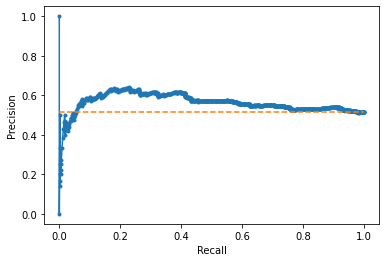

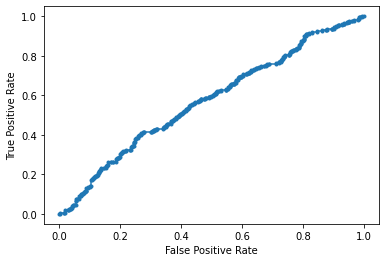

Accuracy: 54.86% Precision: 57.26% Recall: 47.44%
F1: 51.89% MCC: 0.1023
AUPRC: 56.21% AUROC: 57.40%
 accuracy [54.85714285714286]
 precision [57.25806451612904]
 recall [47.43875278396437]
 F1 [51.88794153471377]
 MCC [0.10226574797285588]
 AUPRC [56.2147146168503]
 AUROC [57.40194694521995]
2023-03-27 21:53:46.500907


In [45]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [46]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 56.95% std 1.38
 precision mean 58.19% std 1.74
 recall mean 59.65% std 5.86
 F1 mean 58.76% std 2.96
 MCC mean 0.14% std 0.03
 AUPRC mean 58.00% std 1.82
 AUROC mean 59.13% std 1.53
 accuracy [[57.24137931034483], [56.56108597285068], [56.53710247349824], [56.853932584269664], [58.9041095890411], [55.12965050732808], [56.451612903225815], [58.837209302325576], [58.134243458475545], [54.85714285714286]]
 precision [[59.26724137931034], [56.38766519823789], [58.96805896805897], [58.09935205183585], [60.125260960334025], [57.00757575757576], [57.2265625], [61.48491879350348], [56.10687022900763], [57.25806451612904]]
 recall [[60.043668122270745], [57.9185520361991], [54.29864253393665], [58.605664488017425], [63.01969365426696], [63.771186440677965], [64.82300884955751], [58.498896247240616], [68.05555555555556], [47.43875278396437]]
 F1 [[59.65292841648589], [57.14285714285715], [56.53710247349824], [58.35140997830802], [61.53846153846154], [60.199999999999996], [60.7883